In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

#sklearn functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from utils import utils
import matplotlib.patches as mpatches 

import warnings

warnings.filterwarnings("ignore")

## Volume Bar Sampling

[*********************100%***********************]  1 of 1 completed


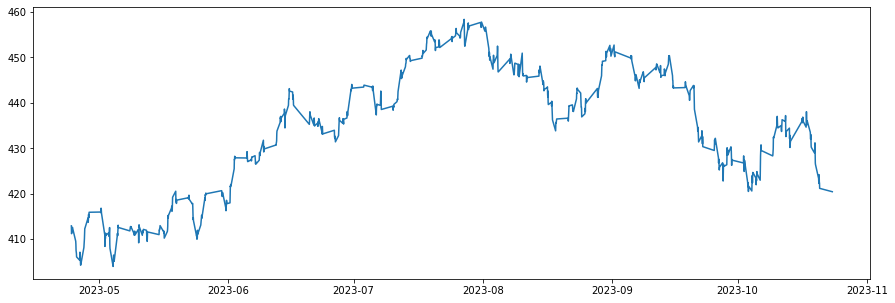

In [47]:
start_date = "2023-04-22"
end_date = "2023-10-22"

#downlaod data
df = yf.download('SPY', start = start_date, end = end_date, interval = '1h')

#reset index
df = df.reset_index()

#rename the index column to Date
df.rename(columns = {'index': 'Date'}, inplace = True)

orig_columns = list(df.columns)
lower_orig_columns = [x.lower() for x in orig_columns]

for i, column_name in enumerate(lower_orig_columns):
    df.rename(columns = {f'{orig_columns[i]}': f'{column_name}'}, inplace = True)


#plot the results
plt.figure(figsize = (15, 5))
plt.plot(df['date'], df['close'])
plt.show()

Find a volume threshold to sample. Here we will use (mean * 10) as the threshold to sample the 'open', 'high', 'close', 'low' values when everytime SPY hits the volume threshold. The function 'create_volume_bar' below returns a dataframe with volume bars.

In [35]:
def create_volume_bar(data, thresh = 2000):
    
    df = data.copy()
    
    #create volume bars
    df_resampled = df.resample('1T', on='date').agg({'open': 'first', 'high': 'max', 'close': 'last', 'low': 'min', 'volume': 'sum'}).fillna(0).reset_index()

    # Create a new dataframe to store the resampled values when volume accumulates 1000 units
    df_new = pd.DataFrame(columns=['open', 'high', 'close', 'low', 'delta', 'o_index', 'date'])

    #volume threshold
    vol_thresh = thresh

    #initial values
    volume_accumulated = 0
    start_time = None

    # Iterate over each row in the resampled dataframe
    for index, row in df_resampled.iterrows():
        volume_accumulated += row['volume']

        if volume_accumulated >= vol_thresh:
            # Calculate the time difference since the last 1000 volume accumulation
            delta = (index - start_time) if start_time else 0

            # Append a new row to the new dataframe
            df_new.loc[index] = [row['open'], row['high'], row['close'], row['low'], delta, index, row['date']]

            # Reset the volume accumulator and start time for the next accumulation
            volume_accumulated = 0
            start_time = None

        if volume_accumulated < vol_thresh and start_time is None:
            # Set the start time when the volume accumulation starts
            start_time = index
            
    return df_new

In [36]:
#mean volume
mean_volume = df['volume'].mean() * 10

#sample volume bar 
data_vb = create_volume_bar(df, mean_volume)

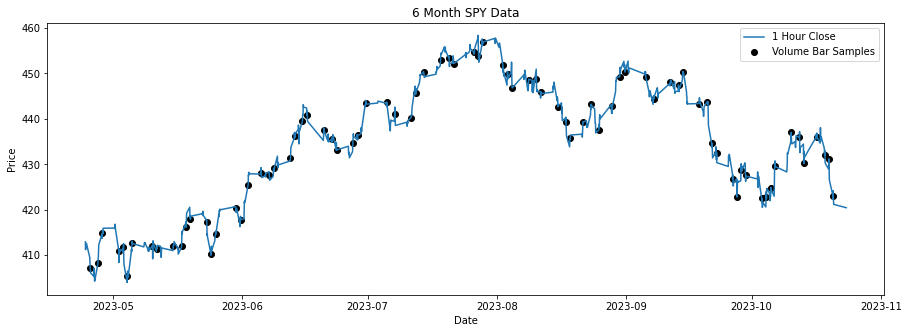

In [37]:
#plot the results
plt.figure(figsize = (15, 5))
plt.title('6 Month SPY Data')
plt.plot(df['date'], df['close'], label = '1 Hour Close')
plt.scatter(data_vb['date'], data_vb['close'], c = 'k', label = 'Volume Bar Samples')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Annotations

### Trend Annotation

Below is a function to generate trends. We will create targets to identify SPY increasing and decreasing a certain value to create trends. We Will also create the trend strength and trend period.

In [48]:
#create targets when SPY goes up 5 points
df = utils.create_targets(df, target_winloss = [5, 0])

In [49]:
#generate trend, strength and period
def generate_trends(data):
    
    data['trend'] = 0
    data['trend_strength'] = np.nan
    data['trend_period'] = np.nan
    
    targets = data['target'].values

    min_indices = np.where(targets == 1)[0]

    max_indices = np.where(targets == 2)[0]

    ind_dict = {}

    for i in min_indices:
        ind_dict[i] = 1

    for i in max_indices:
        ind_dict[i] = 2

    sorted_dict = {k: ind_dict[k] for k in sorted(ind_dict)}

    current_ind = next(iter(sorted_dict))
    current_trend = sorted_dict[current_ind]


    for i, trend in sorted_dict.items():

        if current_trend == trend:
            continue
        elif (current_trend == 1) and (trend == 2):
            data.loc[current_ind:i, 'trend'] = 1
            
            trend_strength = 1 - ((np.arange(current_ind, i, 1) - current_ind) / (i - current_ind))
            
            data.loc[np.arange(current_ind, i, 1), 'trend_strength'] = trend_strength.tolist()
            
            data.loc[current_ind:i, 'trend_period'] = (i - current_ind)
            
            current_ind = i
            current_trend = trend
        elif (current_trend == 2) and (trend == 1):
            data.loc[current_ind:i, 'trend'] = 2
            
            trend_strength = 1 - ((np.arange(current_ind, i, 1) - current_ind) / (i - current_ind))
            
            data.loc[np.arange(current_ind, i, 1), 'trend_strength'] = trend_strength.tolist()
            
            data.loc[current_ind:i, 'trend_period'] = (i - current_ind)
            
            current_ind = i
            current_trend = trend
            
    return data

In [50]:
#generate trends
df_trend = generate_trends(df)

<Figure size 1080x216 with 0 Axes>

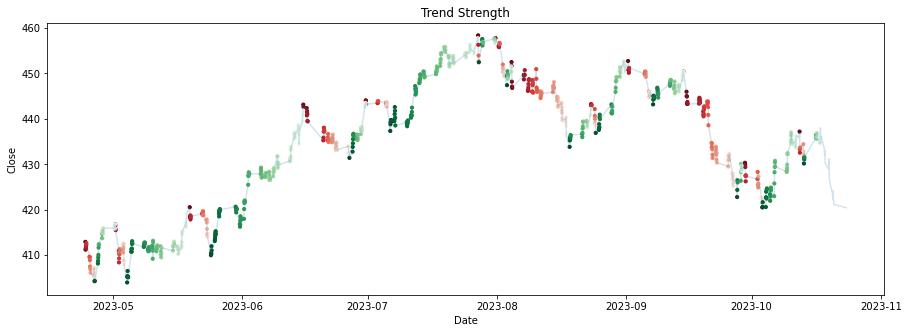

In [57]:
#plot trend strength and period
plt.figure(figsize = (15, 3))

data_plot = df_trend.copy()
colors = {0: 'yellow', 1: 'green', 2: 'red'}

# Create a colormap from light red to dark red
colormap = plt.get_cmap('Reds')
colormap_g = plt.get_cmap('Greens')

# Normalize trend_strength values to the colormap
norm = plt.Normalize(data_plot['trend_strength'].min(), data_plot['trend_strength'].max())

# Create a ScalarMappable for color mapping
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])

sm_g = plt.cm.ScalarMappable(cmap=colormap_g, norm=norm)
sm_g.set_array([])


plt.figure(figsize = (15, 5))
plt.plot(data_plot['date'], data_plot['close'], alpha = 0.2)
plt.scatter(data_plot[data_plot['trend'] == 2]['date'], data_plot[data_plot['trend'] == 2]['close'], c=colormap(norm(data_plot[data_plot['trend'] == 2]['trend_strength'])), cmap=colormap, s = 10)
plt.scatter(data_plot[data_plot['trend'] == 1]['date'], data_plot[data_plot['trend'] == 1]['close'], c=colormap_g(norm(data_plot[data_plot['trend'] == 1]['trend_strength'])), cmap=colormap_g, s = 10)
plt.title('Trend Strength')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

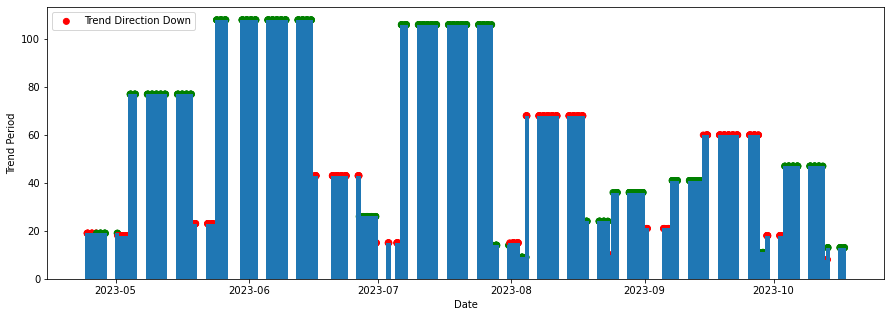

In [63]:
#plot trend period
# # cont_data['date'] = cont_data['o_index']
data_plot = df_trend.copy()
colors = {0: 'yellow', 1: 'green', 2: 'red'}
plt.figure(figsize = (15, 5))
plt.scatter(data_plot['date'], data_plot['trend_period'], c = data_plot['trend'].apply(lambda x: colors[x]), label = 'Trend Direction Down')
plt.bar(data_plot['date'], data_plot['trend_period'])
plt.xlabel('Date')
plt.ylabel('Trend Period')
plt.legend()
plt.show()